In [ ]:
import pandas as pd 
import json
from pathlib import Path  # Imported for path handling (not required in the current script but useful for portability).

# Defined the input file paths (two CSV exports from different dates).
csv_1 = "/content/dados_berna_comparacao_fato_direito_04082025.csv"
csv_2 = "/content/dados_berna_comparacao_fato_direito_24072025.csv"

# Loaded both CSV files into DataFrames.
# sep/encoding can be adjusted if the files use non-default formatting.
df1 = pd.read_csv(csv_1)
df2 = pd.read_csv(csv_2)

# Concatenated both DataFrames into a single dataset (same schema expected).
df = pd.concat([df1, df2], ignore_index=True)

# Optionally removed exact duplicate rows (kept commented to preserve all records by default).
# df = df.drop_duplicates()

# Printed the first 5 records as dictionaries for quick inspection/debugging.
print("===== First 5 examples (dict) =====")
exemplos_5 = df.head(5).to_dict(orient="records")
print(json.dumps(exemplos_5, ensure_ascii=False, indent=2))

# Printed the total number of merged records.
print("\n===== Total records =====")
print(len(df))

# Exported the unified dataset into a single JSON file (list of objects).
out_json = "/content/dados_berna_comparacao_fato_direito_unificado.json"
df.to_json(out_json, orient="records", force_ascii=False, indent=2)

# Confirmed output location.
print(f"\nJSON saved at: {out_json}")

===== 5 primeiros exemplos (dict) =====
[
  {
    "processo_paradigma": "5340099.55.2020.8.09.0023",
    "processo_similar": "5045753.62.2021.8.09.0023",
    "fato_paradigma": ". a parte autora com 50 anos de idade é portador de vários incômodos (enfermidades), conforme demonstra os documentos em anexos, o seu quadro de saúde depende de cuidados médico e uso continuo de medicamentos e repouso. a parte autora não possui qualquer renda, mora sozinho, sobrevivendo de ajuda dos parentes e amigos, o que esta sendo impossível sobreviver dignamente, pois o autor depende de medicamentos, alimentos e outros, estando à mercê da sorte. o benefício, com a lei fundamental de 1988 passou a ser de um salário mínimo, lembrando que tal benefício foi instituído sob a denominação de \"renda mensal vitalícia\", pela lei n.° 6.179/74. o requisito mais controverso, porém, encontra-se no § 3.º, do art. 20, da loas. este dispositivo prescreve, in verbis: art. 20 [...] § 3.º considera-se incapaz de prover a ma

In [ ]:
!pip -q install nltk

import json
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
STOPWORDS_PT = set(stopwords.words("portuguese"))

print("Qtd stopwords (NLTK - portuguese):", len(STOPWORDS_PT))

Qtd stopwords (NLTK - portuguese): 207


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# =========================
# 1) Load data (JSON)
# =========================
JSON_PATH = "/content/dados_berna_comparacao_fato_direito_unificado.json"

TEXT_FIELDS = ["fato_paradigma", "fato_similar", "direito_paradigma", "direito_similar"]

def load_json_df(path, *, json_lines=False, root_key=None):
    if json_lines:
        return pd.read_json(path, lines=True, encoding="utf-8")

    with open(path, "r", encoding="utf-8") as f:
        obj = json.load(f)

    if isinstance(obj, list):
        return pd.DataFrame(obj)

    if isinstance(obj, dict):
        if root_key and root_key in obj and isinstance(obj[root_key], list):
            return pd.DataFrame(obj[root_key])

        for k, v in obj.items():
            if isinstance(v, list) and len(v) > 0 and isinstance(v[0], dict):
                return pd.DataFrame(v)

        return pd.DataFrame([obj])

    raise ValueError("Formato JSON não reconhecido.")

df = load_json_df(JSON_PATH, json_lines=False, root_key=None)

faltando = [c for c in TEXT_FIELDS if c not in df.columns]
if faltando:
    raise KeyError(f"As seguintes colunas esperadas não existem no JSON: {faltando}")

# =========================
# Light cleaning
# =========================
def remove_pontuacao_inicio(text):
    if isinstance(text, str):
        return re.sub(r'^[^\w\s]+', '', text)
    return text

def remove_pontuacao_repetida(text):
    if isinstance(text, str):
        return re.sub(r'([^\w\s])\1{4,}', r'\1\1\1\1', text)
    return text

df[TEXT_FIELDS] = df[TEXT_FIELDS].replace({r'[\r\n]+': ' '}, regex=True)
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)
df[TEXT_FIELDS] = df[TEXT_FIELDS].map(remove_pontuacao_inicio)
df[TEXT_FIELDS] = df[TEXT_FIELDS].map(remove_pontuacao_repetida)

print("N registros (antes):", len(df))
print(df[TEXT_FIELDS].head(2))

N registros (antes): 20000
                                      fato_paradigma  \
0   a parte autora com 50 anos de idade é portado...   
1  a requerente é servidora pública estadual, nas...   

                                        fato_similar  \
0  a parte autora com 47 anos de idade, é portado...   
1  a requerente é servidora pública estadual, nas...   

                                   direito_paradigma  \
0   tal benefício está previsto no artigo 203, in...   
1  ao recebimento da diferença de gratificação na...   

                                     direito_similar  
0  tal benefício está previsto no artigo 203, inc...  
1  ao recebimento da diferença de gratificação na...  


In [ ]:
# -------------------------
# Stopword removal policy:
# - PT-BR stopwords (NLTK)
# - Extra tokens commonly produced by copy/OCR artifacts
# - Punctuation preserved as separate tokens
# -------------------------

from collections import Counter

# Extra tokens removed in addition to the standard stopword list.
EXTRA_REMOVE_TOKENS = {
    "\u00a0",  # NBSP
    "“", "”", "‘", "’", "´", "`",
}

# Tokenizer pattern that keeps punctuation as independent tokens.
_token_pat = re.compile(r"\w+|[^\w\s]", re.UNICODE)

def _fix_punct_spacing(text: str) -> str:
    # Removed spaces before punctuation and normalized repeated whitespace.
    text = re.sub(r"\s+([,.;:!?])", r"\1", text)
    text = re.sub(r"\s{2,}", " ", text).strip()
    return text

def remove_stopwords_keep_punct(text: str, stopwords_set: set, extra_remove: set):
    """
    Removed PT stopwords (word tokens only) while preserving punctuation.
    Returned (clean_text, removed_tokens).
    """
    if not isinstance(text, str) or not text.strip():
        return text, []

    toks = _token_pat.findall(text)
    removed = []
    kept = []

    for t in toks:
        tl = t.lower()

        # Removed explicit junk tokens.
        if t in extra_remove:
            removed.append(t)
            continue

        # Removed stopwords only when the token is a word.
        if re.search(r"\w", t) and tl in stopwords_set:
            removed.append(t)
            continue

        kept.append(t)

    out = " ".join(kept)
    out = _fix_punct_spacing(out)
    return out, removed

# Applied stopword removal per field and collected removal statistics.
removed_counter_all = Counter()
removed_counter_by_field = {f: Counter() for f in TEXT_FIELDS}

df_clean = df.copy()

for field in TEXT_FIELDS:
    new_texts = []
    for txt in df_clean[field].astype(str).tolist():
        cleaned, removed = remove_stopwords_keep_punct(txt, STOPWORDS_PT, EXTRA_REMOVE_TOKENS)
        new_texts.append(cleaned)

        # Counted removed word tokens (lowercased); punctuation excluded.
        removed_counter_all.update([r.lower() for r in removed if re.search(r"\w", r)])
        removed_counter_by_field[field].update([r.lower() for r in removed if re.search(r"\w", r)])

    df_clean[field] = new_texts

print("N registros (depois):", len(df_clean))

print("\n===== 5 primeiros exemplos (após stopwords) =====")
display(df_clean[TEXT_FIELDS].head(5))

print("\n===== Top 30 stopwords removidas (geral) =====")
print(removed_counter_all.most_common(30))

print("\n===== Top 15 stopwords removidas por campo =====")
for f in TEXT_FIELDS:
    print(f"\n[{f}]")
    print(removed_counter_by_field[f].most_common(15))

# Removal policy summary (kept in Portuguese prints as requested).
print("\n===== O que foi removido do dataset (decisão) =====")
print("1) Stopwords padrão PT-BR do NLTK: stopwords.words('portuguese')")
print(f"   - Total na lista: {len(STOPWORDS_PT)}")
print("2) Tokens extras removidos (lixo comum de cópia/OCR):")
print("   -", sorted(list(EXTRA_REMOVE_TOKENS)))
print("Obs.: Mantive números e pontuação; removi apenas stopwords (palavras) + esses símbolos extras.")

N registros (depois): 20000

===== 5 primeiros exemplos (após stopwords) =====


,fato_paradigma,fato_similar,direito_paradigma,direito_similar
0,parte autora 50 anos idade portador vários inc...,"parte autora 47 anos idade, portadora vários i...","tal benefício previsto artigo 203, inciso v, c...","tal benefício previsto artigo 203, inciso v, c..."
1,"requerente servidora pública estadual, nascida...","requerente servidora pública estadual, nascida...",recebimento diferença gratificação natalina: g...,recebimento diferença gratificação natalina: g...
2,"parte autora policial militar estado goiás, as...","parte autora policial militar estado goiás, as...","neste sentido, julgados recentes tribunal just...","neste sentido, julgados recentes tribunal just..."
3,parte autora direito indenização seguro obriga...,parte autora direito indenização seguro obriga...,"lei nº 6. 194 / 74, alterada lei nº 8. 441 / 9...","lei nº 6. 194 / 74, alterada lei nº 8. 441 / 9..."
4,"ano 2006, estado goiás editou lei nº 15. 949 /...","ano 2006, estado goiás editou lei nº 15. 949 /...","inicialmente cumpre esclarecer, termo indeniza...","inicialmente cumpre esclarecer, termo indeniza..."



===== Top 30 stopwords removidas (geral) =====
[('de', 6681823), ('a', 4187165), ('o', 3026712), ('do', 2934188), ('e', 2882457), ('da', 2609606), ('que', 2283092), ('em', 1762612), ('se', 1044890), ('no', 969167), ('não', 902458), ('ao', 868727), ('por', 858021), ('dos', 851011), ('com', 842159), ('os', 721529), ('para', 711357), ('ou', 614328), ('é', 594759), ('na', 587486), ('à', 470333), ('as', 398864), ('pela', 389640), ('como', 373423), ('pelo', 356879), ('ser', 343658), ('nos', 323684), ('sua', 285832), ('das', 273045), ('seu', 259150)]

===== Top 15 stopwords removidas por campo =====

[fato_paradigma]
[('de', 942628), ('a', 582540), ('o', 415295), ('e', 406814), ('do', 371452), ('da', 316021), ('que', 314259), ('em', 255309), ('se', 137522), ('no', 130761), ('com', 127721), ('por', 126511), ('não', 123361), ('para', 113172), ('ao', 101492)]

[fato_similar]
[('de', 941293), ('a', 582977), ('o', 415771), ('e', 406804), ('do', 371155), ('da', 316378), ('que', 314540), ('em', 255

In [ ]:
OUT_JSON = "/content/dados_berna_comparacao_fato_direito_unificado_sem_stopwords.json"

df_clean.to_json(OUT_JSON, orient="records", force_ascii=False, indent=2)

print("JSON limpo salvo em:", OUT_JSON)
print("Total de registros:", len(df_clean))

print("\n===== 5 primeiros registros (dict) =====")
import json as _json
print(_json.dumps(df_clean.head(5).to_dict(orient="records"), ensure_ascii=False, indent=2)[:4000])

JSON limpo salvo em: /content/dados_berna_comparacao_fato_direito_unificado_sem_stopwords.json
Total de registros: 20000

===== 5 primeiros registros (dict) =====
[
  {
    "processo_paradigma": "5340099.55.2020.8.09.0023",
    "processo_similar": "5045753.62.2021.8.09.0023",
    "fato_paradigma": "parte autora 50 anos idade portador vários incômodos ( enfermidades ), conforme demonstra documentos anexos, quadro saúde depende cuidados médico uso continuo medicamentos repouso. parte autora possui qualquer renda, mora sozinho, sobrevivendo ajuda parentes amigos, sendo impossível sobreviver dignamente, pois autor depende medicamentos, alimentos outros, estando mercê sorte. benefício, lei fundamental 1988 passou salário mínimo, lembrando tal benefício instituído sob denominação \" renda mensal vitalícia \", lei n. ° 6. 179 / 74. requisito controverso, porém, encontra - § 3. º, art. 20, loas. dispositivo prescreve, in verbis: art. 20 [... ] § 3. º considera - incapaz prover manutenção pesso

In [ ]:
import os
import math
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

       Campo Textual  Avg. Words  Std. Words  Avg. Chars  Std. Chars  \
0     Fato Paradigma      545.80      870.68     4340.68     6618.89   
1       Fato Similar      543.40      856.55     4326.24     6556.96   
2  Direito Paradigma     1531.65     2295.55    12066.80    15928.19   
3    Direito Similar     1528.98     2291.16    12049.64    15898.96   

   Avg. Sents  LexDiv Avg. (TTR)  Herdan C Avg.      N  
0       47.37               0.49           0.93  20000  
1       47.07               0.49           0.93  20000  
2      162.14               0.40           0.91  20000  
3      161.70               0.40           0.91  20000  


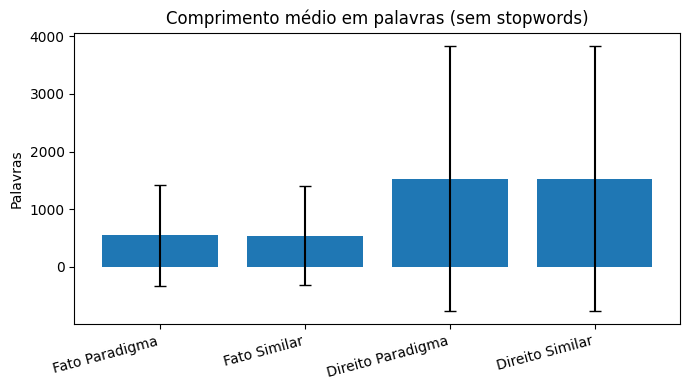

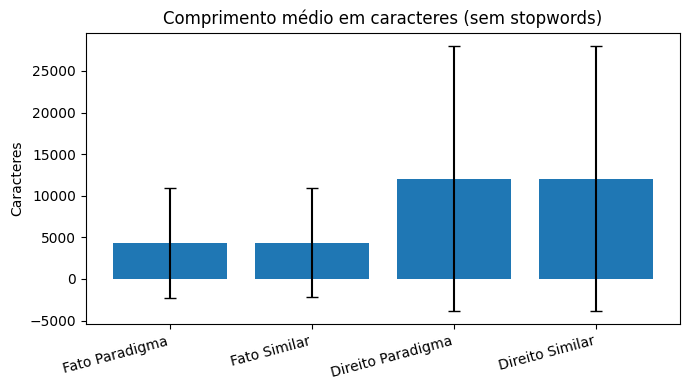

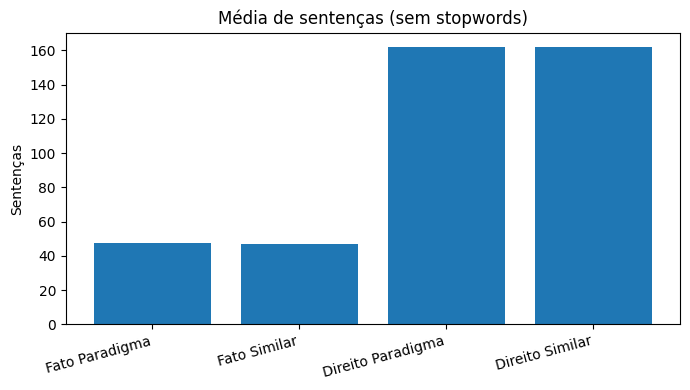

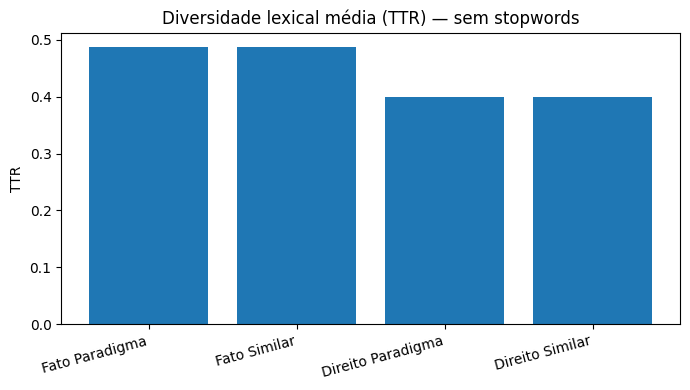

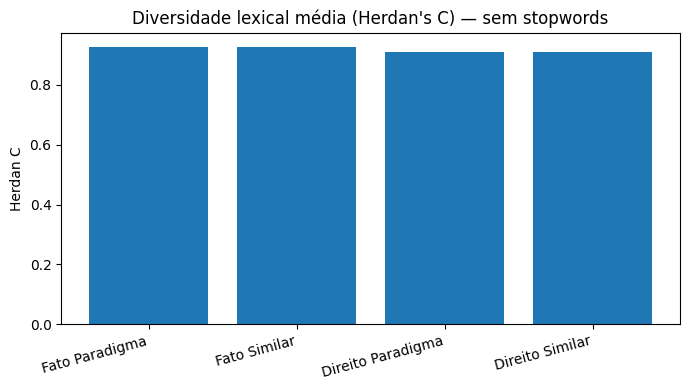

In [ ]:
# =========================
# 2) Basic textual metrics
# =========================
def sent_split_simple(txt):
    return [s for s in re.split(r'(?<=[\.\!\?])\s+', txt) if s.strip()]

def word_tokenize_simple(txt):
    return re.findall(r"\w+|\S", txt, re.UNICODE)

def lexical_diversity(tokens):
    if not tokens:
        return 0.0
    types = len(set([t.lower() for t in tokens if re.search(r"\w", t)]))
    return types / len(tokens)

def herdan_c(tokens):
    toks = [t.lower() for t in tokens if re.search(r"\w", t)]
    V = len(set(toks))
    N = len(toks)
    if V < 2 or N < 2:
        return 0.0
    return math.log(V) / math.log(N)

stats = []
for field in TEXT_FIELDS:
    lengths_words = []
    lengths_chars = []
    lengths_sents = []
    ttrs = []
    herdans = []

    for txt in df_clean[field].astype(str):
        sents = sent_split_simple(txt)
        toks  = word_tokenize_simple(txt)
        lengths_words.append(len([t for t in toks if re.search(r"\w", t)]))
        lengths_chars.append(len(txt))
        lengths_sents.append(len(sents))
        ttrs.append(lexical_diversity(toks))
        herdans.append(herdan_c(toks))

    stats.append({
        "Campo Textual": field.replace("_", " ").title(),
        "Avg. Words": np.mean(lengths_words),
        "Std. Words": np.std(lengths_words),
        "Avg. Chars": np.mean(lengths_chars),
        "Std. Chars": np.std(lengths_chars),
        "Avg. Sents": np.mean(lengths_sents),
        "LexDiv Avg. (TTR)": np.mean(ttrs),
        "Herdan C Avg.": np.mean(herdans),
        "N": len(lengths_words)
    })

stats_df = pd.DataFrame(stats)
print(stats_df.round(2))

def bar_with_error(df_plot, metric, title, ylabel):
    x = np.arange(len(df_plot))
    y = df_plot[metric].values
    std_col = metric.replace("Avg.", "Std.")
    yerr = df_plot[std_col].values if std_col in df_plot.columns else None

    plt.figure(figsize=(7,4))
    plt.bar(x, y, yerr=yerr, capsize=4)
    plt.xticks(x, df_plot["Campo Textual"], rotation=15, ha="right")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

bar_with_error(stats_df, "Avg. Words", "Comprimento médio em palavras (sem stopwords)", "Palavras")
bar_with_error(stats_df, "Avg. Chars", "Comprimento médio em caracteres (sem stopwords)", "Caracteres")
bar_with_error(stats_df, "Avg. Sents", "Média de sentenças (sem stopwords)", "Sentenças")

plt.figure(figsize=(7,4))
plt.bar(np.arange(len(stats_df)), stats_df["LexDiv Avg. (TTR)"].values)
plt.xticks(np.arange(len(stats_df)), stats_df["Campo Textual"], rotation=15, ha="right")
plt.title("Diversidade lexical média (TTR) — sem stopwords")
plt.ylabel("TTR")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.bar(np.arange(len(stats_df)), stats_df["Herdan C Avg."].values)
plt.xticks(np.arange(len(stats_df)), stats_df["Campo Textual"], rotation=15, ha="right")
plt.title("Diversidade lexical média (Herdan's C) — sem stopwords")
plt.ylabel("Herdan C")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

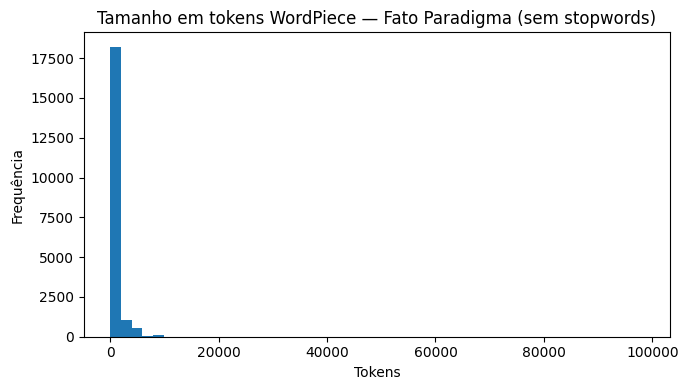

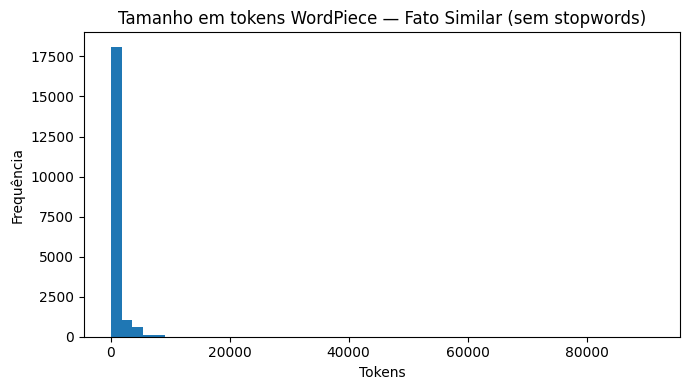

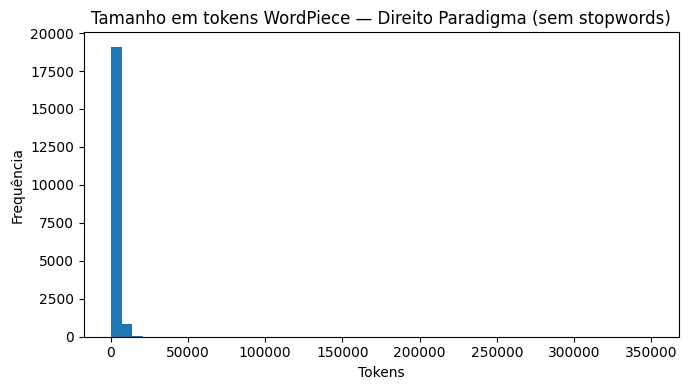

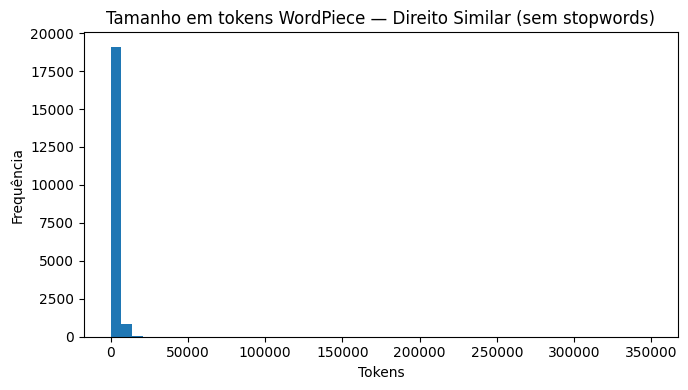

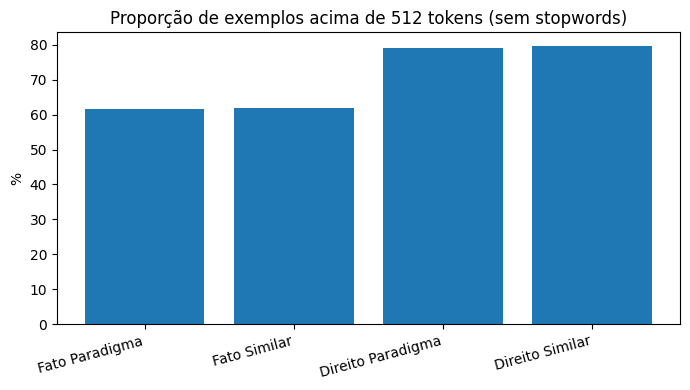

Proporção >512 tokens por campo:
       Campo Textual  % > 512
0     Fato Paradigma    61.50
1       Fato Similar    61.94
2  Direito Paradigma    79.18
3    Direito Similar    79.55


In [ ]:
# =========================
# 3) Length in BERT tokens and % > 512
# =========================
TOKENIZER_NAME = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

def count_wp_tokens(texts):
    tok_lens = []
    for t in texts:
        ids = tokenizer.encode(str(t), add_special_tokens=True, truncation=False)
        tok_lens.append(len(ids))
    return np.array(tok_lens)

bert_len = {}
for field in TEXT_FIELDS:
    lens = count_wp_tokens(df_clean[field].astype(str).tolist())
    bert_len[field] = lens

for field in TEXT_FIELDS:
    plt.figure(figsize=(7,4))
    plt.hist(bert_len[field], bins=50)
    plt.title(f"Tamanho em tokens WordPiece — {field.replace('_',' ').title()} (sem stopwords)")
    plt.xlabel("Tokens")
    plt.ylabel("Frequência")
    plt.tight_layout()
    plt.show()

over512 = []
for field in TEXT_FIELDS:
    vals = bert_len[field]
    pct = 100.0 * (vals > 512).sum() / len(vals)
    over512.append({"Campo Textual": field.replace("_"," ").title(), "% > 512": pct})

over_df = pd.DataFrame(over512)
plt.figure(figsize=(7,4))
plt.bar(np.arange(len(over_df)), over_df["% > 512"].values)
plt.xticks(np.arange(len(over_df)), over_df["Campo Textual"], rotation=15, ha="right")
plt.title("Proporção de exemplos acima de 512 tokens (sem stopwords)")
plt.ylabel("%")
plt.tight_layout()
plt.show()

print("Proporção >512 tokens por campo:")
print(over_df.round(2))

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


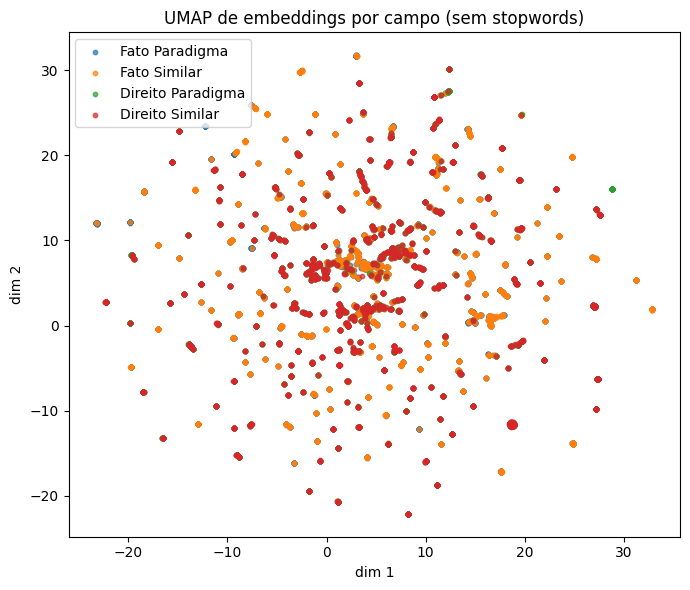

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


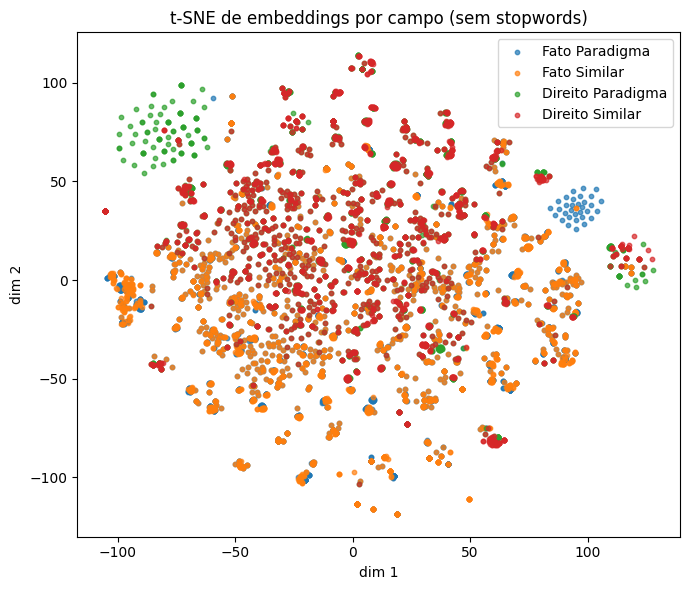

In [ ]:
# =========================
# 4) Embeddings + UMAP and t-SNE
# =========================
EMB_MODEL = "neuralmind/bert-base-portuguese-cased"
embedder = SentenceTransformer(EMB_MODEL)

SAMPLE_MAX = 2000
df_sample = df_clean.sample(n=min(SAMPLE_MAX, len(df_clean)), random_state=42)

items = []
for field in TEXT_FIELDS:
    for txt in df_sample[field].astype(str):
        items.append((txt, field))

texts = [t for t,_ in items]
labels = [f for _,f in items]

embs = embedder.encode(texts, show_progress_bar=True, batch_size=32, convert_to_numpy=True)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
umap_2d = reducer.fit_transform(embs)

plt.figure(figsize=(7,6))
xs = umap_2d[:,0]
ys = umap_2d[:,1]
for f in TEXT_FIELDS:
    mask = np.array([l==f for l in labels])
    plt.scatter(xs[mask], ys[mask], s=10, label=f.replace("_"," ").title(), alpha=0.7)
plt.legend()
plt.title("UMAP de embeddings por campo (sem stopwords)")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.tight_layout()
plt.show()

pca = PCA(n_components=min(50, embs.shape[1]))
embs_50 = pca.fit_transform(embs)
tsne_2d = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42).fit_transform(embs_50)

plt.figure(figsize=(7,6))
xs = tsne_2d[:,0]
ys = tsne_2d[:,1]
for f in TEXT_FIELDS:
    mask = np.array([l==f for l in labels])
    plt.scatter(xs[mask], ys[mask], s=10, label=f.replace("_"," ").title(), alpha=0.7)
plt.legend()
plt.title("t-SNE de embeddings por campo (sem stopwords)")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.tight_layout()
plt.show()
